In [4]:
# check chainer info
%%bash
python -c 'import chainer; chainer.print_runtime_info()'

SyntaxError: invalid syntax (<ipython-input-4-302fcec894ad>, line 2)

In [5]:
# setting datasets
from chainer.datasets import mnist

train_val, test = mnist.get_mnist(withlabel=True, ndim=1)

label: 5


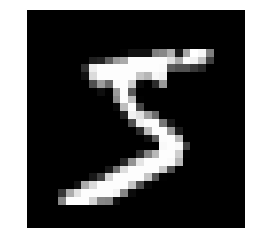

In [6]:
# display data
%matplotlib inline
import matplotlib.pyplot as plt

x, t = train_val[0] # (data, label)
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show
print('label:', t)

In [7]:
# divide data, Training and Validation
from chainer.datasets import split_dataset_random
train, valid = split_dataset_random(train_val, 50000, seed=0) # seed値でランダムな値を固定
print('Training dataset size:', len(train))
print('Validation dataset size:', len(valid))
print('test dataset size:', len(test))

Training dataset size: 50000
Validation dataset size: 10000
test dataset size: 10000


In [8]:
# minibatch processing
from chainer import iterators

batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
valid_iter = iterators.SerialIterator(
    valid,
    batchsize,
    repeat=False,
    shuffle=False
)
test_iter = iterators.SerialIterator(
    test,
    batchsize,
    repeat=False,
    shuffle=False,
)

In [10]:
# Result guarantee
# より厳密なのはchainer.config.cudnn_deterministic
import random
import numpy
import chainer

def reset_seed(seed=0):
    random.seed(seed)
    numpy.random.seed(seed)
    if chainer.cuda.available:
        chainer.cuda.cupy.random.seed(seed)

reset_seed(0)

In [12]:
# make neuralnetwork Link and Function
import chainer.links as L # パラメータを持つ関数
import chainer.functions as F # パラメータを持たない関数
import chainer
class MLP(chainer.Chain):
    
    def __init__(self, n_mid_units=100, n_out=10):
        super(MLP, self).__init__()
        
        # パラメータを持つ層の登録
        with self.init_scope():
            self.l1 = L.Linear(None, n_mid_units) # None, 100 : Noneはその時の入力でユニット数を計算する
            self.l2 = L.Linear(n_mid_units, n_mid_units) # 100, 100
            self.l3 = L.Linear(n_mid_units, n_out) # 100, 10
    
    def __call__(self, x):
        # データを受け取った際のforward計算を書く
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)
    
gpu_id = -1 # 0: gpu -1: cpu

net = MLP()

if gpu_id == 0:
    net.to_gpu(gpu_id)

In [21]:
# 重み行列: W バイアス: b
print('1つ目の全結合層のバイアスパラメータは :', net.l1.b.shape)
print('初期化直後の配列\n', net.l1.b.array)
print('2つ目の全結合層のバイアスパラメータは :', net.l2.b.shape)
print('初期化直後の配列\n', net.l2.b.array)
print('3つ目の全結合層のバイアスパラメータは :', net.l3.b.shape)
print('初期化直後の配列\n', net.l3.b.array)

1つ目の全結合層のバイアスパラメータは : (100,)
初期化直後の配列
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
2つ目の全結合層のバイアスパラメータは : (100,)
初期化直後の配列
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
3つ目の全結合層のバイアスパラメータは : (10,)
初期化直後の配列
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [22]:
#　まだ学習をしていないから重み行列(W)はNone
print("l1\n",net.l1.W.array) # None
print("l2"net.l2.W.array)
print(net.l3.W.array)

None
[[ 0.17640524  0.04001572  0.0978738  ...  0.17858705  0.01269121
   0.04019894]
 [ 0.18831506 -0.1347759  -0.12704849 ...  0.08235042  0.2163236
   0.13365279]
 [-0.03691819 -0.02393792  0.10996596 ...  0.05829537 -0.0399449
   0.03700559]
 ...
 [-0.00552438  0.0130643   0.04406911 ...  0.09722072 -0.09189505
   0.06632405]
 [-0.01334914 -0.15663703 -0.17486514 ...  0.00708476  0.24357285
   0.09716812]
 [-0.09329622  0.28652036 -0.1792048  ...  0.05168722 -0.00329207
   0.12981114]]
[[-2.02117022e-02 -8.33230987e-02  1.73360020e-01  1.90648995e-02
  -1.77810397e-02 -1.08502515e-01  9.72262323e-02  1.43147171e-01
  -2.45073047e-02 -6.23253807e-02 -3.95998880e-02 -1.35852247e-01
   1.32260248e-01  3.44393833e-04 -1.96770106e-05  1.53370395e-01
  -7.73082227e-02 -4.01254930e-02 -1.15356762e-02  1.01155542e-01
   1.51323557e-01  9.17068645e-02  7.28893057e-02  5.52032143e-02
  -2.80323416e-01 -3.96053195e-02 -7.13143647e-02  1.30083367e-01
  -5.52865788e-02  2.07089737e-01 -3.659083